Author: Thomas Esayas <br>
Date: Aug 18, 2022 - Oct 6, 2022

Note: All visualizations and graphs are uneccesarry for the operation of the robot. It is there solely for your comprehension.

# Dependencies

Our imports are data science libraries that help visualize our data

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from math import sin, cos, radians as rad
import cv2 as cv2
from scipy import stats
%matplotlib inline

# Defining Variables

Firstly, in order to aim and launch an object at a certain destination, it would be helpful to know the trajectory. We can define (x1, y1) as our start, and (x3, y3) as our destination

In [ ]:
target = (2, 4)

x3 = target[0]
y3 = target[1]


# Graphing our Parabola (Unused Section)

There are an infinite amount of parabolas that can cross two points, and that's why we have a third point.

(x2, y2) is a soft-coded way to ensure that the parabola is what we would expect from a launching machine. 



We can use these three points to extract the coefficients ($A$, $B$, $C$) needed for a polynomial. 
$y = Ax^2 + Bx + C$

# Derivation

## Finding acceleration

In normal projectile motion (without air resistance), the only force present would be gravity.

> $F_{net} = -mg = ma$ <br>
  $F_{net_x} = 0$ <br>
  $F_{net_y} = mg$

However, in the real world, there exists a force called Drag Force or simply Drag. Drag can be described as:

> $F_{D} = \frac{1}{2}\rho v^2 C_DA$

But we'll simplify it to make it easy on the eyes:

>$F_{D} = Dv^2$ <br>
 $D = \frac{1}{2}\rho C_DA$

Assuming air is still, we can say velocity relative to the ground is equal to velocity relative to the air. Like ground friction, drag acts in the opposite direction of motion. Let's rewrite it and find it's components.

>$F_{D} = Dv\vec{v}$ 
><ul>
 <li> $F_{D_x} = -Dvv_{x}$
 <li> $F_{D_y} = Dvv_{y}$
</ul>

Now since we're including drag force, we have to change our $F_{net}$.

>$F_{net} = -mg - Dv\vec{v} = ma$

And we'll go ahead and do that for the components of $F_{net}$

>$F_{net_x} = -Dvv_{x} = ma_{x}$<br>
 $F_{net_y} = -mg - Dvv_{y} = ma_{y}$

Now we can solve for acceleration in each component.

>$a_{x} = \frac{-Dvv_{x}}{m}$<br>
>
>
> $a_{y} = -g-\frac{- Dvv_{y}}{m}$


## Using kinematics to find position

### Finding Velocity
Acceleration is changing as velocity changes; however, if we assume that acceleration is constant over a small time interval, $\Delta t$, we can say acceleration is constant.

If we know the coordinates and velocity and time $t$, we can find the coordinates and velocity at $t + \Delta t$.

> $v = v_{o} + a t$

$v_{o}$ would be velocity at the start of the interval, and $v$ would be the velocity at the end of the interval.

Applying this kineamtic equation with these variables would look something like this:

> $v_{x} + \Delta v_{x} = v_{x} + a_{x} \Delta t$

And it would be very similar for the y component as well.

### Finding position

Finding position will require a defined velocity, so we'll use average velocity within the time interval.

>$v_{avg} = \frac{(v+Δv) + (v)}{2} = \frac{2v + Δv}{2} = v+\frac{Δv}{2}$

And now we can find the total change in position using both average velocity and kinematics:

>$\Delta x = (v_{x} + \frac{\Delta v_{x}}{2})Δt = v_{x}Δt + \frac{1}{2}a_{x}(Δt)^2$

This also will look similarly for the y component.

Knowing this we can finally determine the coordinates of the projectile at the end of the interval.

>$ x + Δx = x + v_{x}Δt + \frac{1}{2}a_{x}(Δt)^2$ <br>
>$ y + Δy = y + v_{y}Δt + \frac{1}{2}a_{y}(Δt)^2$

Which means in order to proceed, we'd need to know: 
>$x$<br> $y$<br> $v_{x}$<br> $v_{y}$

# Code

## Data Gathering

This block defines gravity and D, which we defined earlier. It also translates the mathemeatical functions for the components of acceleration into programming functions for later use.

In [ ]:
g = 9.81

p = 1.3 # Density of Air
C = 0.55 # Drag Coefficient
A = 0.0034 # Silhouette Area
m = 0.6

D = (p*C*A)/(2)

def findAccX(Vx, Vy):
  V = np.hypot(Vx, Vy) # V is the hypotnuse of Vx and Vy
  return (-D/m)*(V * Vx)

def findAccY(Vx, Vy):
  V = np.hypot(Vx, Vy) # V is the hypotnuse of Vx and Vy
  return (-D/m)*(V * Vy) - g

We're defining a function that finds the motion of a projectile with drag for each interval. We use the equations from our derivation and iterate for a maximum of three seconds. Then we return the data of the motion of the projectile.

In [ ]:
def motion(x, y, Vx, Vy):
  g = 9.81
  initialX = x
  initialY = y
  initialVx = Vx
  initialVy = Vy
  Ax = 0.0
  Ay = 0.0

  t = 0.00 # t
  timeInterval = 0.1 # Delta t

  data = [[x, y, Vx, Vy, Ax, Ay, t]]

  while t <= 3.0: # Euler's Method
    Ax = findAccX(Vx, Vy)
    Ay = findAccY(Vx, Vy)

    Vx = Vx + Ax*timeInterval
    Vy = Vy + Ay*timeInterval

    x = x + Vx*timeInterval + 1/2*(Ax)*(timeInterval**2)
    y = y + Vy*timeInterval + 1/2*(Ay)*(timeInterval**2)

    data.append([x, y, Vx, Vy, Ax, Ay, t])

    t += timeInterval



  return data

This saves data from all possible target-hitting parabolas.

In [ ]:
allPossibilities = []

def saveData(data):
  allPossibilities.append(data)

This function finds the "optimal" parabola, which is really just the trajectory with the lowest final velocity. It uses the data saved from allPossibilities.

In [ ]:
def findOptimal(data, target):
  optimal = data
  for i in range(len(data)): # For every possibility
    v = float("inf")
    newV = abs(np.hypot(data[i][-1][2], data[i][-1][3]))
    if newV < v: # Save the data lowest velocity
      optimal = data[i]
  return optimal

This function iterates through all the data points of a given trajectory data, and finds if any of those points seem to hit the target.

In [ ]:
def isHitTarget(data, target): 
  for i in range(len(data)):
    x = data[i][0]
    y = data[i][1]

    targetX = target[0]
    targetY = target[1]
    
    delta = 0.1

    if targetX - delta <= x <= targetX + delta and targetY - delta <= y <= targetY + delta:
      saveData(data)
      return True
  return False


This for loop essentially finds the trajectory for thousands of different velocities/angles. It's redundant to run it over and over again, so the data will be saved on some form of storage.

In [ ]:
from math import sin, cos, tan, atan, pi, radians as rad, degrees as deg

l = 0.64 
counter = 0

for theta in np.arange(0,91, 1): ## For every angle...
  for velocity in np.arange(0, 10, 0.1): ## For every possible velocity from 0.0 m/s - 10.0 m/s
    data = motion(l*cos(rad(theta)), l*sin(rad(theta)), velocity*sin(rad(theta)), velocity*cos(rad(theta)))
    if isHitTarget(data, target):
      counter += 1

print("Possible trajectories: " , counter)

optimal = findOptimal(allPossibilities, target)


Possible trajectories:  4


## Data Analysis/Display

This makes all the data into a pandas Dataframe, which is essentially Excel for Python. This is extremely useful for Data Analysis.

In [ ]:
df = pd.DataFrame(optimal)
df = df.rename(columns={0: 'X', 1: 'Y', 2 : 'Vx', 3 : 'Vy',4: 'Ax', 5: 'Ay', 6 : 't'})

Collectiong data at collision point

In [ ]:
collision = df.loc[df['X'] >= target[0] - 0.10].iloc[0]

This is turning the raw data into a dataframe (which can be though of as spreadsheet). It is extremely useful for doing analysis with data.

In [ ]:
df = pd.DataFrame(optimal)
df = df.rename(columns={0: 'X', 1: 'Y', 2 : 'Vx', 3 : 'Vy',4: 'Ax', 5: 'Ay', 6 : 't'})

The following plots the position and its derivatives using the newly made dataframe.

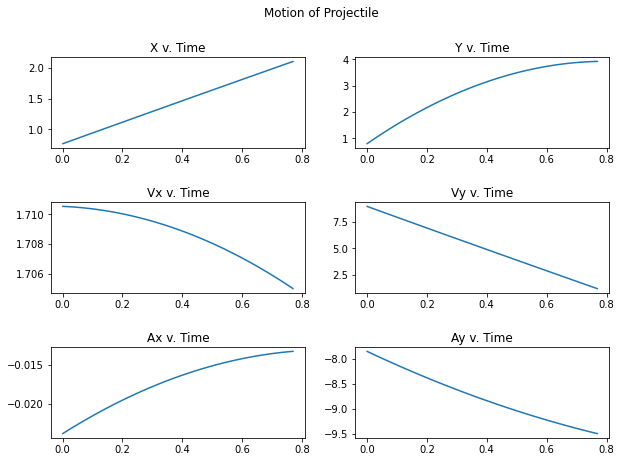

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(7)
fig.set_figwidth(10)

i = 0 

for n in range(3):
  for m in range (2):
    p = np.poly1d(np.polyfit(df['t'], df[df.columns[i]], 2)) # Making the polynomial
    x = np.linspace(0, collision['t']*1.1, 100) # X is from 0 - target, made up of 100 lines
    y = p(x) # Y is the model (p) of X
    with sns.axes_style("darkgrid"): # Makes everything look nice
      axs[n, m].plot(x, y) # Plots data
      axs[n, m].set_title(df.columns[i] + " v. Time")
    i += 1

plt.subplots_adjust(wspace = 0.20, hspace = 0.60)

fig.suptitle('Motion of Projectile')

plt.show()

Finds needed launch velocity and angle

In [ ]:
launchVelocity = np.hypot(df['Vx'][0], df['Vy'][0])
launchAngle = deg((np.arctan([df['Vy'][0]/df['Vx'][0]]))[0])

print(launchVelocity, launchAngle)


9.9 80.0


# Rotational Kinematics


Now, having our initial launch velocity and our angle, we can make it into something understandable by our motor.

> $θ_{c} =$ Angle of Launch with respect to the horizontal <br>
> $θ_{l} =$ Angle of Catapult with respect to the horizontal

Since we defined $θ_{c}$ at the end of the code section, we can find $θ_{l}$ through $θ_{l} = 90 - θ_{c}$ because trig makes life easy.

Since we'll be working in terms of angular kinematics, it'll be useful to define our variables in terms of their angular counterparts.

> $ω = \frac{v}{r}$ <br>

We can also assume our initial angular velocity and angle is zero.
Knowing this we can use our third kinematic equation to find angular acceleration

> $ω^2 = ω_{0}^2 + 2α$ $(Δθ)$ <br>
> $α = \frac{ω^2 - ω_{0}^2}{2(Δθ)}$

In addition to angular acceleration, we need to find moment of inertia to get the required torque.

Since our arm is a complex object, we will determine moment of inertia of the arm as a rod, and the projectile as a point mass:

> $I = \frac{1}{3}M_{1}L^2 + M_{2}r^2$

And now we can find torque, power, etc.

> $τ = Iα$ <br>
> $P = τω$ <br>
> $t = \frac{2(Δθ)}{ω + ω_{0}}$

The following is the programmatic representation of the above.

In [ ]:
#Point Mass at the end
rodMass = .264
holderMass = 0.013
ballMass = .056


pivotX = 0.10 # The distance from the end which the arm pivots about
centerX = 0.30 # The center of mass of the arm

def angMotion(t):
  ## Setting our variables
  seconds = t
  ang = rad(launchAngle)
  angVel = launchVelocity/l # Desired final angular velocity
  angAcc = angVel/seconds # The Angular Acceleration required to have the desired angular velocity within a predetermined amount of time

  ## Calculating necessary variables
  momentInertia = 1/3*(rodMass)*(l**2) + (holderMass + ballMass)*(l-0.08)**2 # Moment of Inertia of the arm

  torqueRod = momentInertia*angAcc # Torque required to rotate the rod
  gTorque = -rodMass*g*centerX # Gravitational torque

  
  netTorque = torqueRod - gTorque

  power = netTorque*angVel

  return [netTorque, angAcc]
  #print(f"rpm: {rpm} \nrotational time: {seconds} s \ntorque: {netTorque} Nm\npower: {power}\nangular acceleration: {angAcc}")


This is the torque-speed curve graph of our specific motor. It helps translate our required torque to RPM. Data is provided by the motor manufacturer and adapted into a programmatic context.

(0.0, 300.0)

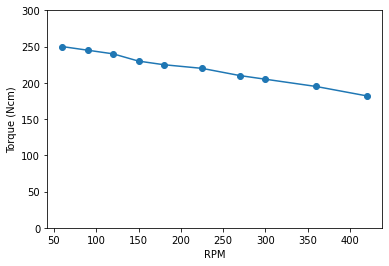

In [ ]:
rpmTorqueData = [[60,250],[90,245],[120,240],[150,230],[180,225],[225,220],[270,210],[300, 205],[360,195],[420,182]]
rpmTorque = pd.DataFrame(rpmTorqueData, columns=['RPM','Torque (Ncm)'])

slope, intercept, r, p, std_err = stats.linregress(rpmTorque['Torque (Ncm)'], rpmTorque['RPM'])

def findRPM(torque):
  return slope*(torque + intercept

plt.scatter(rpmTorque['RPM'], rpmTorque['Torque (Ncm)'])
plt.plot(rpmTorque['RPM'], rpmTorque['Torque (Ncm)'])
plt.xlabel("RPM")
plt.ylabel("Torque (Ncm)")
plt.ylim(0,300)


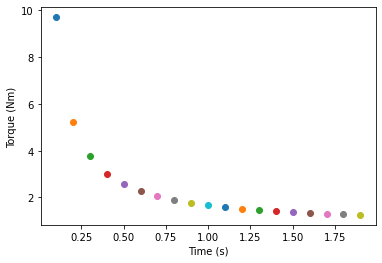

In [ ]:
#The range of available torque + time combinations that result in the same final velocity
for t in np.arange(0.1, 2, 0.1):
  plt.scatter(t, angMotion(t)[0])
  plt.xlabel("Time (s)")
  plt.ylabel("Torque (Nm)")

reqTorqueData = (0.25, findRPM(angMotion(0.25)[0]))

# Animation (Non-functioning)

To ensure that the catapult will work as expected, an animation of how it works based on our previous data may be helpful

In [ ]:
!pip install pygame

     |▎                               | 215 kB 28.3 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame
from pygame import draw, Color
from google.colab.patches import cv2_imshow
from google.colab import output
from time import sleep
from matplotlib import animation
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation 
   
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim =(-1, 5), 
                ylim =(0, 5)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 
   
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    x = np.linspace(0, 5, 100)
   
    # plots a sine graph
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 200, interval = 20, blit = True)
  

# Object Detection


In [ ]:
import cv2
from cvzone.PoseModule import PoseDetector
from cvzone.HandTrackingModule import HandDetector
from time import sleep

detector = PoseDetector()
detectorH = HandDetector(detectionCon=0.8, maxHands=2)

cap = cv2.VideoCapture(0)

def track():
    i = 0

    shoulderSpanList = []
    HandS_DisplacementList = []

    while i < 30:
        success, img = cap.read()
        img = detector.findPose(img)
        hands, img = detectorH.findHands(img)  
        lmlist, bbox = detector.findPosition(img)
        #Shoulders = 12, 11

        for d, x in enumerate(lmlist):
            cv2.putText(img = img, text = str(d), fontFace = cv2.FONT_HERSHEY_COMPLEX,fontScale =  1, org = (x[1],x[2]), color = (200,200,200))
        try:
            shoulderSpanList.append(lmlist[11][1] - lmlist[12][1])
        except:
            print("None")

        try:
            HandS_DisplacementList.append(lmlist[12][2] - lmlist[20][2])
        except:
            print("None")

        if hands:
            # Hand 1
            hand1 = hands[0]
            lmList1 = hand1["lmList"]  # List of 21 Landmarks points
            bbox1 = hand1["bbox"]  # Bounding Box info x,y,w,h
            centerPoint1 = hand1["center"]  # center of the hand cx,cy
            handType1 = hand1["type"]  # Hand Type Left or Right



            fingers1 = detectorH.fingersUp(hand1)

            if len(hands) == 2:
                hand2 = hands[1]
                lmList2 = hand2["lmList"]  # List of 21 Landmarks points
                bbox2 = hand2["bbox"]  # Bounding Box info x,y,w,h
                centerPoint2 = hand2["center"]  # center of the hand cx,cy
                handType2 = hand2["type"]  # Hand Type Left or Right

                fingers2 = detectorH.fingersUp(hand2)
                # print(fingers1, fingers2)
                # length, info, img = detectorH.findDistance(lmList1[8], lmList2[8], img) # with draw
                length, info, img = detectorH.findDistance(centerPoint1, centerPoint2, img)  # with draw


        cv2.imshow("Result", img)
        cv2.waitKey(1)

        i += 1

    shoulderSpan = sum(shoulderSpanList) / len(shoulderSpanList)
    HS = sum(HandS_DisplacementList) / len(HandS_DisplacementList)

    avgShoulderSpan = .40  # In Meters

    ratio = avgShoulderSpan / shoulderSpan  # Pixel to Meter Ratio

    avgHeight = 1.77
    shoulderHeight = avgHeight * 0.84375

    return ratio
        #X = ratio / 0.0026175
        #Y = shoulderHeight + HS * ratio


#print(X, Y)
def calibration(): # Approximately 15 second test that helps determine the distance from the camera
    pixRatio = []
    meters = []
    for i in range(1,4):
        print(f"Move {i} meters away")
        sleep(3)
        print("Tracking")
        pixRatio.append(track())
        meters.append(i)

    slope, intercept, r, p, std_err = stats.linregress(pixRatio, meters)
    return [slope, intercept]

reg = calibration()
print("move somewhere")
sleep(5)
print(reg[0]*track() + reg[1])
print("done")


ModuleNotFoundError: ignored

# Motor Control

This section will not work here, but this is the code that runs within the Raspberry Pi that makes things work.

In [ ]:
from time import sleep
import RPi.GPIO as GPIO

DIR = 20   # Direction GPIO Pin
STEP = 21  # Step GPIO Pin
CW = 1     # Clockwise Rotation
CCW = 0    # Counterclockwise Rotation
SPR = 200   # Steps per Revolution (360 / 1.8)

GPIO.setmode(GPIO.BCM)
GPIO.setup(DIR, GPIO.OUT)
GPIO.setup(STEP, GPIO.OUT)
GPIO.output(DIR, CW)

step_count = SPR

def launch(duration, RPM):
    delay = RPM/SPR/2/60

    while i <= duration:
      GPIO.output(STEP, GPIO.HIGH)
      sleep(delay)
      GPIO.output(STEP, GPIO.LOW)
      sleep(delay)

      i += delay*2

In [ ]:
def peek():  # Takes a 'peek' at the user's position
    detector = PoseDetector()
    cap = cv2.VideoCapture(0)
    success, img = cap.read()
    img = detector.findPose(img)
    # sleep(0.5)
    lmlist, bbox = detector.findPosition(img)

    return lmlist[11][1]

def rotate():
    while not (960 * 0.8 < i < 960 * 1.2):
        i = peek()

        if i < 960: # Defines dirrection to Spin
            direction = 'CW'
        else:
            direction = 'CCW'

In [ ]:
launch(reqTorqueData[0], reqTorqueData[1])